# Using GPUs & TPUs with TF-Agents

### Profile in-notebook training

> Note: this notebook will only be useful if you have an accelerator (GPU or TPU) attached to the instance.

#### Goals

* Use the [TensorBoard Profiler](https://www.tensorflow.org/guide/profiler) to profile the RL training job, and compare this to other ML training jobs
* Visualize information such as operation statistics on different devices, tracing, etc. 
* Discuss these performance characteristics with respect to decisions in the code base (e.g., the structure of the Agent class), the use of TF helpers like `@tf.function`, and the order of operations in the input data pipeline

**Why?**
* Accelerators like GPUs and TPUs are certainly advantageous, but they are also the most expensive component(s) of a training job
* Before scaling to a full training job, it's best to make sure we are fully utilizing the chosen device(s), and doing this in-notebook can quickly help uncover any red flags 

We'll mainly look to address any bottlenecks in the input pipeline

## Load notebook config

* use the prefix defined in `00-env-setup`

In [1]:
VERSION        = "v2"                       # TODO
PREFIX         = f'rec-bandits-{VERSION}'   # TODO

print(f"PREFIX: {PREFIX}")

PREFIX: rec-bandits-v2


In [2]:
# staging GCS
GCP_PROJECTS             = !gcloud config get-value project
PROJECT_ID               = GCP_PROJECTS[0]

# GCS bucket and paths
BUCKET_NAME              = f'{PREFIX}-{PROJECT_ID}-bucket'
BUCKET_URI               = f'gs://{BUCKET_NAME}'

config = !gsutil cat {BUCKET_URI}/config/notebook_env.py
print(config.n)
exec(config.n)


PROJECT_ID               = "hybrid-vertex"
PROJECT_NUM              = "934903580331"
LOCATION                 = "us-central1"

REGION                   = "us-central1"
BQ_LOCATION              = "US"
VPC_NETWORK_NAME         = "ucaip-haystack-vpc-network"
VERTEX_SA                = "934903580331-compute@developer.gserviceaccount.com"

PREFIX                   = "rec-bandits-v2"
VERSION                  = "v2"

BUCKET_NAME              = "rec-bandits-v2-hybrid-vertex-bucket"
BUCKET_URI               = "gs://rec-bandits-v2-hybrid-vertex-bucket"
DATA_GCS_PREFIX          = "data"
DATA_PATH                = "gs://rec-bandits-v2-hybrid-vertex-bucket/data"
VOCAB_SUBDIR             = "vocabs"
VOCAB_FILENAME           = "vocab_dict.pkl"

VPC_NETWORK_FULL         = "projects/934903580331/global/networks/ucaip-haystack-vpc-network"

BIGQUERY_DATASET_NAME    = "mvlens_rec_bandits_v2"
BIGQUERY_TABLE_NAME      = "training_dataset"

REPOSITORY               = "rl-movielens-rec-bandits-v2"

DOCKERNAM

### imports

In [3]:
import wrapt

wrapt.__version__

'1.14.1'

In [4]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [5]:
import functools
from collections import defaultdict
from typing import Callable, Dict, List, Optional, TypeVar
from datetime import datetime
import time
from pprint import pprint
import pickle as pkl

# logging
import logging
logging.disable(logging.WARNING)

import matplotlib.pyplot as plt
import numpy as np

# google cloud
from google.cloud import aiplatform as vertex_ai
from google.cloud import storage

# tensorflow
import tensorflow as tf

from tf_agents.bandits.metrics import tf_metrics as tf_bandit_metrics
from tf_agents.metrics import tf_metrics

from tf_agents.bandits.agents import neural_epsilon_greedy_agent
from tf_agents.bandits.agents import neural_linucb_agent
from tf_agents.bandits.networks import global_and_arm_feature_network

from tf_agents.specs import tensor_spec
from tf_agents.trajectories import time_step as ts
from tf_agents.bandits.policies import policy_utilities
from tf_agents.trajectories import trajectory
from tf_agents.policies import policy_saver
from tf_agents.specs import array_spec

from tf_agents.bandits.specs import utils as bandit_spec_utils
from tf_agents.train.utils import spec_utils
from tf_agents.train.utils import strategy_utils
from tf_agents.train.utils import train_utils as tfa_train_utils
from tf_agents.utils import common

# GPU
from numba import cuda 
import gc

import sys
sys.path.append("..")

# this repo
from src import train_utils as train_utils
from src import reward_factory as reward_factory
from src.data import data_utils as data_utils
from src.data import data_config as data_config
from src.trainer import train_perarm as train_perarm
from src.networks import encoding_network as emb_features
from src.agents import agent_factory as agent_factory

# tf exceptions and vars
if tf.__version__[0] != "2":
    raise Exception("The trainer only runs with TensorFlow version 2.")

T = TypeVar("T")

In [6]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [9]:
device = cuda.get_current_device()
device.reset()
gc.collect()

14

In [10]:
# cloud storage client
storage_client = storage.Client(project=PROJECT_ID)

# Vertex client
vertex_ai.init(project=PROJECT_ID, location=LOCATION)

## Specify dataset

In [11]:
EXAMPLE_GEN_GCS_PATH = data_config.EXAMPLE_GEN_GCS_PATH
GCS_DATA_PATH = f"{BUCKET_URI}/{EXAMPLE_GEN_GCS_PATH}"

print(f"GCS_DATA_PATH: {GCS_DATA_PATH}")

!gsutil ls $GCS_DATA_PATH

GCS_DATA_PATH: gs://rec-bandits-v2-hybrid-vertex-bucket/data/movielens/m1m
gs://rec-bandits-v2-hybrid-vertex-bucket/data/movielens/m1m/mv_b128_g12_a16/
gs://rec-bandits-v2-hybrid-vertex-bucket/data/movielens/m1m/mv_b128_g12_a16_v4/
gs://rec-bandits-v2-hybrid-vertex-bucket/data/movielens/m1m/mv_b128_g12_a16_v5/
gs://rec-bandits-v2-hybrid-vertex-bucket/data/movielens/m1m/train/
gs://rec-bandits-v2-hybrid-vertex-bucket/data/movielens/m1m/val/
gs://rec-bandits-v2-hybrid-vertex-bucket/data/movielens/m1m/vocabs/


### Generate Vocabs

In [12]:
EXISTING_VOCAB_FILE = f'gs://{BUCKET_NAME}/{EXAMPLE_GEN_GCS_PATH}/vocabs/{VOCAB_FILENAME}'
print(f"Downloading vocab...")

os.system(f'gsutil -q cp {EXISTING_VOCAB_FILE} .')
print(f"Downloaded vocab from: {EXISTING_VOCAB_FILE}\n")

filehandler = open(VOCAB_FILENAME, 'rb')
vocab_dict = pkl.load(filehandler)
filehandler.close()

# for key in vocab_dict.keys():
#     pprint(key)

Downloaded vocab from: gs://rec-bandits-v2-hybrid-vertex-bucket/data/movielens/m1m/vocabs/vocab_dict.pkl



### train config

In [13]:
NUM_OOV_BUCKETS       = 1
GLOBAL_EMBEDDING_SIZE = 12
MV_EMBEDDING_SIZE     = 16 #32

NUM_GLOBAL_FEATURES   = len(data_utils.USER_FEATURE_NAMES)     # 6
NUM_ARM_FEATURES      = len(data_utils.MOVIE_FEATURE_NAMES)    # 5

EXPECTED_GLOBAL_DIM   = GLOBAL_EMBEDDING_SIZE * NUM_GLOBAL_FEATURES
EXPECTED_PER_ARM_DIM  = MV_EMBEDDING_SIZE * NUM_ARM_FEATURES

EXPECTED_GLOBAL_LAYERS   = [
    EXPECTED_GLOBAL_DIM,
    int(EXPECTED_GLOBAL_DIM/2),
    int(EXPECTED_GLOBAL_DIM/4)
]
EXPECTED_ARM_LAYERS      = [
    EXPECTED_PER_ARM_DIM,
    int(EXPECTED_PER_ARM_DIM/2),
    int(EXPECTED_PER_ARM_DIM/4)
]
EXPECTED_FIRST_COMMON_LAYER = EXPECTED_GLOBAL_LAYERS[-1] + EXPECTED_ARM_LAYERS[-1]
EXPECTED_COMMON_LAYERS = [
    int(EXPECTED_FIRST_COMMON_LAYER),
    # int(EXPECTED_FIRST_COMMON_LAYER/2),
    int(EXPECTED_FIRST_COMMON_LAYER/4)
]

print(f"NUM_OOV_BUCKETS        : {NUM_OOV_BUCKETS}")
print(f"GLOBAL_EMBEDDING_SIZE  : {GLOBAL_EMBEDDING_SIZE}")
print(f"MV_EMBEDDING_SIZE      : {MV_EMBEDDING_SIZE}")
print(f"EXPECTED_GLOBAL_DIM    : {EXPECTED_GLOBAL_DIM}")
print(f"EXPECTED_PER_ARM_DIM   : {EXPECTED_PER_ARM_DIM}")
print(f"EXPECTED_GLOBAL_LAYERS : {EXPECTED_GLOBAL_LAYERS}")
print(f"EXPECTED_ARM_LAYERS    : {EXPECTED_ARM_LAYERS}")
print(f"EXPECTED_COMMON_LAYERS : {EXPECTED_COMMON_LAYERS}")

NUM_OOV_BUCKETS        : 1
GLOBAL_EMBEDDING_SIZE  : 12
MV_EMBEDDING_SIZE      : 16
EXPECTED_GLOBAL_DIM    : 72
EXPECTED_PER_ARM_DIM   : 64
EXPECTED_GLOBAL_LAYERS : [72, 36, 18]
EXPECTED_ARM_LAYERS    : [64, 32, 16]
EXPECTED_COMMON_LAYERS : [34, 8]


In [14]:
BATCH_SIZE             = 128
EVAL_BATCH_SIZE        = 1
NUM_ACTIONS            = 2 
#this is kinda deceptive - 
#our approach is to learn by "flashing" one movie rating at a time per user context. 
#The n_actions = show/don't show the movie with one degree of freedom (n-1)

print(f"BATCH_SIZE      : {BATCH_SIZE}")
print(f"EVAL_BATCH_SIZE : {EVAL_BATCH_SIZE}")
print(f"NUM_ACTIONS     : {NUM_ACTIONS}")

BATCH_SIZE      : 128
EVAL_BATCH_SIZE : 1
NUM_ACTIONS     : 2


#### confirm GLOBAL and PER_ARM DIMs

**we only need a subset of data for profiling!**

In [15]:
SPLIT = "train" # "train" | "val"

train_files = []
for blob in storage_client.list_blobs(f"{BUCKET_NAME}", prefix=f'{EXAMPLE_GEN_GCS_PATH}/{SPLIT}'):
    if '.tfrecord' in blob.name:
        train_files.append(blob.public_url.replace("https://storage.googleapis.com/", "gs://"))
        
train_files = train_files[:3]
train_dataset = tf.data.TFRecordDataset(train_files)
train_dataset = train_dataset.map(data_utils._parse_function)

In [16]:
for i in range(1):
    
    iterator = iter(train_dataset.batch(1))
    data = next(iterator)

data

{'target_movie_genres': <tf.Tensor: shape=(1, 10), dtype=string, numpy=
 array([[b'Drama', b'UNK', b'UNK', b'UNK', b'UNK', b'UNK', b'UNK', b'UNK',
         b'UNK', b'UNK']], dtype=object)>,
 'target_movie_id': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'1775'], dtype=object)>,
 'target_movie_rating': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([4.], dtype=float32)>,
 'target_movie_title': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Live Flesh (1997)'], dtype=object)>,
 'target_movie_year': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([1997])>,
 'target_rating_timestamp': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([974612615])>,
 'user_age': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([50])>,
 'user_gender': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'M'], dtype=object)>,
 'user_id': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'2173'], dtype=object)>,
 'user_occupation_text': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'pr

In [17]:
embs = emb_features.EmbeddingModel(
    vocab_dict = vocab_dict,
    num_oov_buckets = NUM_OOV_BUCKETS,
    global_emb_size = GLOBAL_EMBEDDING_SIZE,
    mv_emb_size = MV_EMBEDDING_SIZE,
    max_genre_length = data_config.MAX_GENRE_LENGTH
)

embs

In [18]:
test_globals = embs._get_global_context_features(data)

GLOBAL_DIM = test_globals.shape[1]            
# shape checks out at batch_dim, nactions, arm feats
print(f"GLOBAL_DIM: {GLOBAL_DIM}")

test_globals

GLOBAL_DIM: 72


<tf.Tensor: shape=(1, 72), dtype=float32, numpy=
array([[-0.00220969, -0.01018505,  0.03136306, -0.03691041,  0.0088677 ,
        -0.01294257,  0.02216968,  0.03370644, -0.04281315, -0.04963579,
        -0.00932394, -0.03629516, -0.01433527,  0.04646407, -0.01049136,
         0.03159623,  0.00824474,  0.02213852, -0.04088575,  0.04068065,
        -0.04546126, -0.04512074, -0.04038326, -0.00164672,  0.04483819,
        -0.02248036,  0.00616931,  0.02903417, -0.0345687 ,  0.00898182,
        -0.02653583, -0.03184617, -0.01271646, -0.02575951, -0.02175512,
        -0.02507622, -0.02845078,  0.02747995, -0.02340014,  0.00135168,
         0.00598501, -0.03019683,  0.01175339, -0.03679283, -0.01561902,
         0.0294814 ,  0.04204804,  0.03707682, -0.01908903, -0.02194713,
        -0.02616794,  0.02912897,  0.01162267,  0.01644954,  0.01413251,
        -0.04123377, -0.00247125, -0.04864487, -0.04342648,  0.02916935,
         0.02900752, -0.00703911,  0.03902322,  0.0445024 , -0.02140472,
  

In [19]:
test_arms = embs._get_per_arm_features(data)

PER_ARM_DIM = test_arms.shape[1]            
# shape checks out at batch_dim, nactions, arm feats
print(f"PER_ARM_DIM: {PER_ARM_DIM}")

test_arms

PER_ARM_DIM: 64


<tf.Tensor: shape=(1, 64), dtype=float32, numpy=
array([[-0.00312338,  0.00774918,  0.00215518, -0.03376938, -0.01384886,
        -0.00552088, -0.02043545, -0.0337787 , -0.04608624,  0.02826986,
        -0.03434776, -0.03464084,  0.00946363, -0.02597234, -0.04594671,
        -0.01866   ,  0.0047385 , -0.03076395, -0.04440791,  0.03802906,
        -0.03064857,  0.03217075,  0.01391791,  0.02225424,  0.00942134,
        -0.01371497, -0.00309979, -0.02641685, -0.027082  ,  0.03396977,
         0.0128768 , -0.00965741,  0.04813839, -0.04599638,  0.04745925,
        -0.03878559,  0.03860198, -0.03012933, -0.02489975,  0.00726052,
        -0.03632771,  0.03394934,  0.02678188, -0.00469298, -0.02702544,
        -0.00903589, -0.04123338,  0.03622668,  0.21292283, -0.12284189,
        -0.03208231,  0.24443881, -0.06082946,  0.12944238, -0.2139914 ,
         0.22663778, -0.06235003,  0.08919692,  0.23596717,  0.24711834,
        -0.03020471,  0.16739988,  0.23102047, -0.09080356]],
      dtype=f

### TensorSpecs

#### Observation Spec

In [20]:
observation_spec = {
    'global': tf.TensorSpec([GLOBAL_DIM], tf.float32),
    'per_arm': tf.TensorSpec([NUM_ACTIONS, PER_ARM_DIM], tf.float32) #excluding action dim here
}
observation_spec

{'global': TensorSpec(shape=(72,), dtype=tf.float32, name=None),
 'per_arm': TensorSpec(shape=(2, 64), dtype=tf.float32, name=None)}

#### Action Spec

In [21]:
action_spec = tensor_spec.BoundedTensorSpec(
    shape=[], 
    dtype=tf.int32,
    minimum=tf.constant(0),            
    maximum=NUM_ACTIONS-1, # n degrees of freedom and will dictate the expected mean reward spec shape
    # name="action_spec"
)

action_spec

BoundedTensorSpec(shape=(), dtype=tf.int32, name=None, minimum=array(0, dtype=int32), maximum=array(1, dtype=int32))

#### TimeStep Spec

In [22]:
time_step_spec = ts.time_step_spec(
    observation_spec = observation_spec, 
    # reward_spec = _reward_spec
)
time_step_spec

TimeStep(
{'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'observation': {'global': TensorSpec(shape=(72,), dtype=tf.float32, name=None),
                 'per_arm': TensorSpec(shape=(2, 64), dtype=tf.float32, name=None)},
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})

#### Reward Spec

In [23]:
from tf_agents.specs import array_spec

reward_spec = {
    "reward": array_spec.ArraySpec(shape=[BATCH_SIZE], dtype=np.float32, name="reward")
}

In [24]:
reward_tensor_spec = train_utils.from_spec(reward_spec)
reward_tensor_spec

{'reward': TensorSpec(shape=(128,), dtype=tf.float32, name='reward')}

## Distribution strategy

Use `strategy_utils` to generate a strategy. Under the hood, passing the parameter:

* `use_gpu = False` returns `tf.distribute.get_strategy()`, which uses CPU
* `use_gpu = True` returns `tf.distribute.MirroredStrategy()`, which uses all GPUs that are visible to TensorFlow on one machine

In [25]:
use_gpu = True
use_tpu = False

distribution_strategy = strategy_utils.get_strategy(tpu=use_tpu, use_gpu=use_gpu)
distribution_strategy

In [26]:
NUM_REPLICAS = distribution_strategy.num_replicas_in_sync
NUM_REPLICAS

1

### Config

In [27]:
# ================================
# Agents
# ================================
AGENT_TYPE      = 'epsGreedy' # 'LinUCB' | 'LinTS |, 'epsGreedy' | 'NeuralLinUCB'

# Parameters for linear agents (LinUCB and LinTS).
AGENT_ALPHA     = 0.1

# Parameters for neural agents (NeuralEpsGreedy and NerualLinUCB).
EPSILON         = 0.01
LR              = 0.05

# Parameters for NeuralLinUCB
ENCODING_DIM    = 1
EPS_PHASE_STEPS = 1000
NUM_EVAL_STEPS  = 10000

# ==================================
# Agent's Preprocess Network layers
# ==================================
NETWORK_TYPE       = "commontower" # 'dotproduct' | 'dotproduct'

GLOBAL_LAYERS      = [GLOBAL_DIM, int(GLOBAL_DIM/2), int(GLOBAL_DIM/4)]
ARM_LAYERS         = [PER_ARM_DIM, int(PER_ARM_DIM/2), int(PER_ARM_DIM/4)]
FIRST_COMMON_LAYER = GLOBAL_LAYERS[-1] + ARM_LAYERS[-1] # min(GLOBAL_LAYERS[-1], ARM_LAYERS[-1])

COMMON_LAYERS = [
    int(FIRST_COMMON_LAYER), 
    # int(FIRST_COMMON_LAYER/2),
    int(FIRST_COMMON_LAYER/4)
]

if AGENT_TYPE == 'NeuralLinUCB':
    NETWORK_TYPE = 'commontower'
    ENCODING_DIM = COMMON_LAYERS[-1]
    
if NETWORK_TYPE == 'dotproduct':
    assert GLOBAL_LAYERS[0] == ARM_LAYERS[0]

HPARAMS = {
    "batch_size": BATCH_SIZE,
    "eval_batch_size" : EVAL_BATCH_SIZE,
    "num_actions": NUM_ACTIONS,
    "model_type": AGENT_TYPE,
    "network_type": NETWORK_TYPE,
    "global_layers": GLOBAL_LAYERS,
    "per_arm_layers": ARM_LAYERS,
    "common_layers": COMMON_LAYERS,
    "learning_rate": LR,
    "epsilon": EPSILON,
    "num_eval_steps": NUM_EVAL_STEPS,
}
pprint(HPARAMS)

{'batch_size': 128,
 'common_layers': [34, 8],
 'epsilon': 0.01,
 'eval_batch_size': 1,
 'global_layers': [72, 36, 18],
 'learning_rate': 0.05,
 'model_type': 'epsGreedy',
 'network_type': 'commontower',
 'num_actions': 2,
 'num_eval_steps': 10000,
 'per_arm_layers': [64, 32, 16]}


### trajectory function

In [28]:
with distribution_strategy.scope():
    
    embs = emb_features.EmbeddingModel(
        vocab_dict = vocab_dict,
        num_oov_buckets = NUM_OOV_BUCKETS,
        global_emb_size = GLOBAL_EMBEDDING_SIZE,
        mv_emb_size = MV_EMBEDDING_SIZE,
        max_genre_length = data_config.MAX_GENRE_LENGTH
    )
    
    def _trajectory_fn(element): # hparams
    
        """Converts a dataset element into a trajectory."""
        global_features = embs._get_global_context_features(element)
        arm_features = embs._get_per_arm_features(element)

        # Adds a time dimension.
        arm_features = train_utils._add_outer_dimension(arm_features)

        # obs spec
        observation = {
            bandit_spec_utils.GLOBAL_FEATURE_KEY:
                train_utils._add_outer_dimension(global_features),
        }

        reward = train_utils._add_outer_dimension(reward_factory._get_rewards(element))

        # To emit the predicted rewards in policy_info, we need to create dummy
        # rewards to match the definition in TensorSpec for the ones specified in
        # emit_policy_info set.
        dummy_rewards = tf.zeros([HPARAMS['batch_size'], 1, HPARAMS['num_actions']])
        policy_info = policy_utilities.PerArmPolicyInfo(
            chosen_arm_features=arm_features,
            # Pass dummy mean rewards here to match the model_spec for emitting
            # mean rewards in policy info
            predicted_rewards_mean=dummy_rewards,
            bandit_policy_type=tf.zeros([HPARAMS['batch_size'], 1, 1], dtype=tf.int32)
            # policy_utilities.create_bandit_policy_type_tensor_spec(shape=[1]) 
            # policy_utilities.BanditPolicyType.GREEDY
            # tf.zeros([batch_size, 1, 1], dtype=tf.int32)
        )

        if HPARAMS['model_type'] == 'neural_ucb':
            policy_info = policy_info._replace(
                predicted_rewards_optimistic=dummy_rewards
            )

        return trajectory.single_step(
            observation=observation,
            action=tf.zeros_like(
                reward, 
                dtype=tf.int32
            ),  # Arm features are copied from policy info, put dummy zeros here
            policy_info=policy_info,
            reward=reward,
            discount=tf.zeros_like(reward)
        )

In [29]:
# print(f"test_traj_v1.action.shape: {test_traj_v1.action.shape}")
# print(f"test_traj_v1.discount.shape: {test_traj_v1.discount.shape}") 
# print(f"test_traj_v1.observation.shape: {test_traj_v1.observation['global'].shape}") 
# print(f"test_traj_v1.reward.shape: {test_traj_v1.reward.shape}") 

## Create Agent

> Note: writting distributions and historgrams of gradients and variables will negatively impact training performance

* set `summarize_grads_and_vars = False` for best training performance
* keep `debug_summaries = True` to track training metrics (e.g., loss / regret)

In [30]:
with distribution_strategy.scope():
    
    global_step = tf.compat.v1.train.get_or_create_global_step()
    
    agent = agent_factory.PerArmAgentFactory._get_agent(
        agent_type = AGENT_TYPE,
        network_type = NETWORK_TYPE,
        time_step_spec = time_step_spec,
        action_spec = action_spec,
        observation_spec=observation_spec,
        global_layers = GLOBAL_LAYERS,
        arm_layers = ARM_LAYERS,
        common_layers = COMMON_LAYERS,
        agent_alpha = AGENT_ALPHA,
        learning_rate = LR,
        epsilon = EPSILON,
        train_step_counter = global_step,
        output_dim = ENCODING_DIM,
        eps_phase_steps = EPS_PHASE_STEPS,
        summarize_grads_and_vars = False,
        debug_summaries = True
    )
    
    agent.initialize()

print(f"Agent: {agent.name}")

if NETWORK_TYPE:
    print(f"NETWORK_TYPE: {NETWORK_TYPE}")

Agent: NeuralEpsGreedyAgent
NETWORK_TYPE: commontower


### GPU stuff

* `TF_GPU_THREAD_MODE=gpu_private` ensures that GPU kernels are launched from their own dedicated threads, and don't get queued behind tf.data work.

In [31]:
import os

TF_GPU_THREAD_COUNT   = '1'      # '1' | '4' | '8'

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['TF_GPU_THREAD_MODE']='gpu_private'
os.environ['TF_GPU_THREAD_COUNT']=f"{TF_GPU_THREAD_COUNT}"
os.environ['TF_GPU_ALLOCATOR']='cuda_malloc_async'

## Vertex Experiment

In [32]:
EXPERIMENT_NAME   = f'02-acc-bandit-v1' # customize as needed

# new experiment
invoke_time       = time.strftime("%Y%m%d-%H%M%S")
RUN_NAME          = f'run-{invoke_time}'

CHECKPT_DIR       = f"{BUCKET_URI}/{EXPERIMENT_NAME}/chkpoint"
BASE_OUTPUT_DIR   = f"{BUCKET_URI}/{EXPERIMENT_NAME}/{RUN_NAME}"
LOG_DIR           = f"{BASE_OUTPUT_DIR}/logs"
ROOT_DIR          = f"{BASE_OUTPUT_DIR}/root"       # Root directory for writing logs/summaries/checkpoints.
ARTIFACTS_DIR     = f"{BASE_OUTPUT_DIR}/artifacts"  # Where the trained model will be saved and restored.

vertex_ai.init(
    project=PROJECT_ID,
    location=REGION,
    experiment=EXPERIMENT_NAME
)

print(f"EXPERIMENT_NAME   : {EXPERIMENT_NAME}")
print(f"RUN_NAME          : {RUN_NAME}\n")
print(f"CHECKPT_DIR       : {CHECKPT_DIR}")
print(f"BASE_OUTPUT_DIR   : {BASE_OUTPUT_DIR}")
print(f"LOG_DIR           : {LOG_DIR}")
print(f"ROOT_DIR          : {ROOT_DIR}")
print(f"ARTIFACTS_DIR     : {ARTIFACTS_DIR}")

EXPERIMENT_NAME   : 02-acc-bandit-v1
RUN_NAME          : run-20240313-201026

CHECKPT_DIR       : gs://rec-bandits-v2-hybrid-vertex-bucket/02-acc-bandit-v1/chkpoint
BASE_OUTPUT_DIR   : gs://rec-bandits-v2-hybrid-vertex-bucket/02-acc-bandit-v1/run-20240313-201026
LOG_DIR           : gs://rec-bandits-v2-hybrid-vertex-bucket/02-acc-bandit-v1/run-20240313-201026/logs
ROOT_DIR          : gs://rec-bandits-v2-hybrid-vertex-bucket/02-acc-bandit-v1/run-20240313-201026/root
ARTIFACTS_DIR     : gs://rec-bandits-v2-hybrid-vertex-bucket/02-acc-bandit-v1/run-20240313-201026/artifacts


### TB Summary writer

In [33]:
# ====================================================
# TB summary writer
# ====================================================
with distribution_strategy.scope():
    train_summary_writer = tf.compat.v2.summary.create_file_writer(
        f"{LOG_DIR}", flush_millis=10 * 1000
    )

    train_summary_writer.set_as_default()

## Train loops

In [38]:
NUM_EPOCHS           = 1
NUM_ITER_STEPS       = 50
STEPS_PER_LOOP       = 1
LOG_INTERVAL         = 10
CHKPT_INTERVAL       = 1000
NUM_EVAL_STEPS       = 100
ASYNC_STEPS_PER_LOOP = 1

print(f"NUM_EPOCHS           : {NUM_EPOCHS}")
print(f"NUM_ITER_STEPS       : {NUM_ITER_STEPS}")
print(f"STEPS_PER_LOOP       : {STEPS_PER_LOOP}")
print(f"LOG_INTERVAL         : {LOG_INTERVAL}")
print(f"CHKPT_INTERVAL       : {CHKPT_INTERVAL}")
print(f"NUM_EVAL_STEPS       : {NUM_EVAL_STEPS}")
print(f"ASYNC_STEPS_PER_LOOP : {ASYNC_STEPS_PER_LOOP}")

NUM_EPOCHS           : 1
NUM_ITER_STEPS       : 50
STEPS_PER_LOOP       : 1
LOG_INTERVAL         : 10
CHKPT_INTERVAL       : 1000
NUM_EVAL_STEPS       : 100
ASYNC_STEPS_PER_LOOP : 1


In [39]:
TOTAL_TRAIN_TAKE = NUM_ITER_STEPS * HPARAMS['batch_size']
TOTAL_TRAIN_TAKE

6400

In [40]:
#start the timer and training
start_time = time.time()

# tf.profiler.experimental.start(LOG_DIR, options=profiler_options)
metric_results, agent = train_perarm.train_perarm(
    agent = agent,
    reward_spec = reward_tensor_spec,
    epsilon = HPARAMS['epsilon'],
    global_dim = GLOBAL_DIM,
    per_arm_dim = PER_ARM_DIM,
    num_epochs = NUM_EPOCHS,
    num_iterations = NUM_ITER_STEPS,
    steps_per_loop = STEPS_PER_LOOP,
    num_eval_steps = NUM_EVAL_STEPS,
    # data
    batch_size = HPARAMS['batch_size'],
    eval_batch_size = HPARAMS['eval_batch_size'],
    # functions
    _trajectory_fn = _trajectory_fn,
    # _run_bandit_eval_fn = _run_bandit_eval,
    # train intervals
    chkpt_interval = CHKPT_INTERVAL,
    log_interval = LOG_INTERVAL,
    # dirs
    bucket_name = BUCKET_NAME,
    data_dir_prefix_path = f"{EXAMPLE_GEN_GCS_PATH}",
    log_dir = LOG_DIR,
    model_dir = ARTIFACTS_DIR,
    # root_dir = ROOT_DIR,
    chkpoint_dir = CHECKPT_DIR,
    async_steps_per_loop = ASYNC_STEPS_PER_LOOP,
    resume_training_loops = False,
    use_gpu = True,
    use_tpu = False,
    profiler = True,
    global_step = global_step,
    total_train_take = TOTAL_TRAIN_TAKE, # TODO - remove?
    train_summary_writer = train_summary_writer,
    # additional_metrics = metrics,
    cache_train_data = False,
    strategy = distribution_strategy,
    # saver=saver,
)
# tf.profiler.experimental.stop()
end_time = time.time()
runtime_mins = int((end_time - start_time) / 60)
print(f"complete train job in {runtime_mins} minutes")

distribution_strategy: <tensorflow.python.distribute.mirrored_strategy.MirroredStrategy object at 0x7f0e17b83160>
number of train_files: 2
Inpsecting agent policy from train_peram file...
agent.policy: <tf_agents.policies.epsilon_greedy_policy.EpsilonGreedyPolicy object at 0x7f0e177b5a20>
Inpsecting agent policy from train_peram file: Complete
setting checkpoint_manager: gs://rec-bandits-v2-hybrid-vertex-bucket/02-acc-bandit-v1/chkpoint
agent.train_step_counter: 0
starting train loop...
epoch: 1
step = 10: loss = 14.050000190734863
step = 20: loss = 2.1700000762939453
step = 30: loss = 3.440000057220459
step = 40: loss = 1.340000033378601
step = 50: loss = 1.1200000047683716
runtime_mins: 0
saved trained policy to: gs://rec-bandits-v2-hybrid-vertex-bucket/02-acc-bandit-v1/run-20240313-201026/artifacts
saved trained policy to: gs://rec-bandits-v2-hybrid-vertex-bucket/02-acc-bandit-v1/chkpoint
complete train job in 0 minutes


## Evaluate Train job

In [41]:
# len(metric_results)
metric_results[-1]

1.1207393

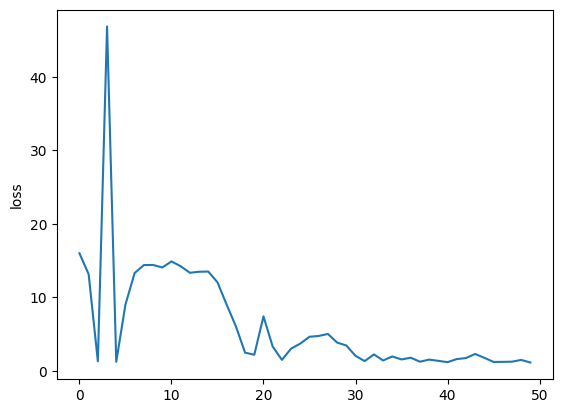

In [42]:
import matplotlib.pyplot as plt

plt.plot(metric_results)
plt.ylabel('loss')
plt.show()

### GPU profiling

#### Load TensorBoard

> on the right-hand side, find `PROFILE` in the drop down:

<img src="imgs/getting_profiler.png" 
     align="center" 
     width="850"
     height="850"/>
     
<!-- tf_vertex_agents/imgs/getting_profiler.png -->

In [43]:
LOG_DIR

'gs://rec-bandits-v2-hybrid-vertex-bucket/02-acc-bandit-v1/run-20240313-201026/logs'

In [44]:
from tensorboard import notebook
notebook.list() # View open TensorBoard instances

Known TensorBoard instances:
  - port 6006: logdir gs://rec-bandits-v2-hybrid-vertex-bucket/02-big-local-bandits-rec-bandits-v2/run-20240301-042649/logs (started 12 days, 15:36:58 ago; pid 3837675)
  - port 6006: logdir gs://rec-bandits-v2-hybrid-vertex-bucket/02x-new-data-loading-v3/run-20240307-012852/logs (started 6 days, 18:43:20 ago; pid 1590886)
  - port 6006: logdir gs://rec-bandits-v2-hybrid-vertex-bucket/02b-deep-bandits-rec-bandits-v2/run-20240214-180454/logs (started 28 days, 1:52:50 ago; pid 3029265)


In [45]:
# %load_ext tensorboard
%reload_ext tensorboard

In [46]:
%tensorboard --logdir=$LOG_DIR

**Finished**